In [1]:
using Lux, LuxCUDA, Optimisers, Random, Zygote, Plots, TaylorDiff

In [2]:
function generate_data(rng::AbstractRNG)
    x = reshape(Float64.(collect(range(-2.0f0, 2.0f0, 128))), (1, 128))
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, (1, 128)) .* 0.1f0
    return (x, y)
end

generate_data (generic function with 1 method)

In [3]:
rng = MersenneTwister()
Random.seed!(rng, 1)

x = reshape(Float32.(collect(range(0, 2π, length=50))), 1,50) 
y = reshape(Float32.(sin.(x)), 1, 50)
data = (x, y)

(Float32[0.0 0.12822828 … 6.154957 6.2831855], Float32[0.0 0.12787716 … -0.12787738 1.7484555f-7])

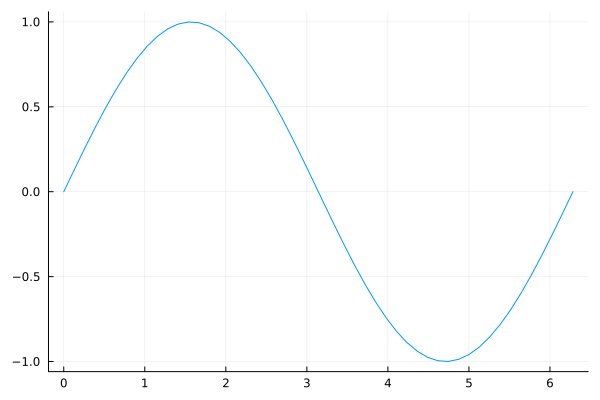

In [4]:
plot(x[1, :],y[1, :], legend=false)

In [14]:
model = Chain(Dense(1 => 30, relu), Dense(30 => 30, relu), Dense(30 => 1))

Chain(
    layer_1 = Dense(1 => 30, relu),     # 60 parameters
    layer_2 = Dense(30 => 30, relu),    # 930 parameters
    layer_3 = Dense(30 => 1),           # 31 parameters
)         # Total: 1_021 parameters,
          #        plus 0 states.

In [15]:
opt = Adam(0.03f0)

Adam(0.03, (0.9, 0.999), 1.0e-8)

In [78]:
# Define the function to apply the model
function f(x)
    return Lux.apply(model, x, ps, st)[1]
end

dy_dx(y,x) = TaylorDiff.derivative.(f, x, Val(1))

 
dy_dx(f,x) 

MethodError: MethodError: no method matching (::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True})(::TaylorScalar{Float32, 1}, ::@NamedTuple{weight::Matrix{Float32}, bias::Vector{Float32}}, ::@NamedTuple{})
The object of type `Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

Closest candidates are:
  (::Dense)(!Matched::AbstractArray, ::Any, ::NamedTuple)
   @ Lux ~/.julia/packages/Lux/CXGnc/src/layers/basic.jl:339


In [53]:
data[1]

1×50 Matrix{Float32}:
 0.0  0.128228  0.256457  0.384685  …  5.8985  6.02673  6.15496  6.28319

In [54]:
x

1×50 Matrix{Float32}:
 0.0  0.128228  0.256457  0.384685  …  5.8985  6.02673  6.15496  6.28319

In [59]:
function loss_function(model, ps, st, data)
     x = data[1]
     f(x) = Lux.apply(model, x, ps, st)[1]
     #derivative = TaylorDiff.derivative.(f, x, Val(1))
     #println(derivative)
     mse_loss = MSELoss()(f(x), data[2])
     return mse_loss, st, ()
end
ps, st = Lux.setup(rng, model)
loss_function(model, ps, st, data)

(2.5471315f0, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()), ())

In [33]:
tstate = Training.TrainState(model, ps, st, opt)

TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 30, relu), layer_2 = Dense(30 => 30, relu), layer_3 = Dense(30 => 1)), nothing)
    # of parameters: 1021
    # of states: 0
    optimizer: Adam(0.03, (0.9, 0.999), 1.0e-8)
    step: 0

In [34]:
grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
Lux.Training.apply_gradients(ts, grads) 

InexactError: InexactError: Bool(-0.25575432f0)

In [35]:
 
# Training loop
epochs = 5000
for epoch in 1:epochs
    grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
    tstate = Lux.Training.apply_gradients(ts, grads)
    if epoch % 100 == 0
        println("Epoch: $epoch, Loss: $loss")
    end
end


InexactError: InexactError: Bool(-0.25575432f0)

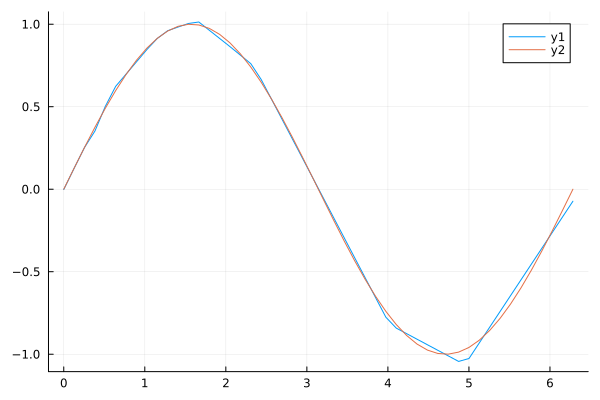

In [31]:
y_pred =  Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1] 
plot(x[1, :], y_pred[1, :])
plot!(x[1, :], y[1, :])